In [ ]:
!pip3 install --upgrade --quiet google-cloud-aiplatform


In [ ]:
!gcloud config list


[compute]
region = us-central1
[core]
account = 763050299616-compute@developer.gserviceaccount.com
disable_usage_reporting = True
project = vertexai-tutorial-479115
universe_domain = googleapis.com
[dataproc]
region = us-central1

Your active configuration is: [default]


In [ ]:
PROJECT_ID = 'vertexai-tutorial-479115'
BUCKET_URI = 'gs://vertextai-tutorial-bucket-philip'
REGION = 'us-central1'


In [ ]:
#initatize the aiplatform

In [ ]:
from google.cloud import aiplatform as ai

ai.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_URI)


In [ ]:
#training with AutoMl

In [ ]:
import pandas as pd

# Path to your CSV file in GCS bucket
gcs_path = "gs://vertextai-tutorial-bucket-philip/dry_bean.csv"

beans = pd.read_csv(gcs_path)

beans.head()


,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


In [ ]:
beans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             13611 non-null  int64  
 1   Perimeter        13611 non-null  float64
 2   MajorAxisLength  13611 non-null  float64
 3   MinorAxisLength  13611 non-null  float64
 4   AspectRation     13611 non-null  float64
 5   Eccentricity     13611 non-null  float64
 6   ConvexArea       13611 non-null  int64  
 7   EquivDiameter    13611 non-null  float64
 8   Extent           13611 non-null  float64
 9   Solidity         13611 non-null  float64
 10  roundness        13611 non-null  float64
 11  Compactness      13611 non-null  float64
 12  ShapeFactor1     13611 non-null  float64
 13  ShapeFactor2     13611 non-null  float64
 14  ShapeFactor3     13611 non-null  float64
 15  ShapeFactor4     13611 non-null  float64
 16  Class            13611 non-null  object 
dtypes: float64(1

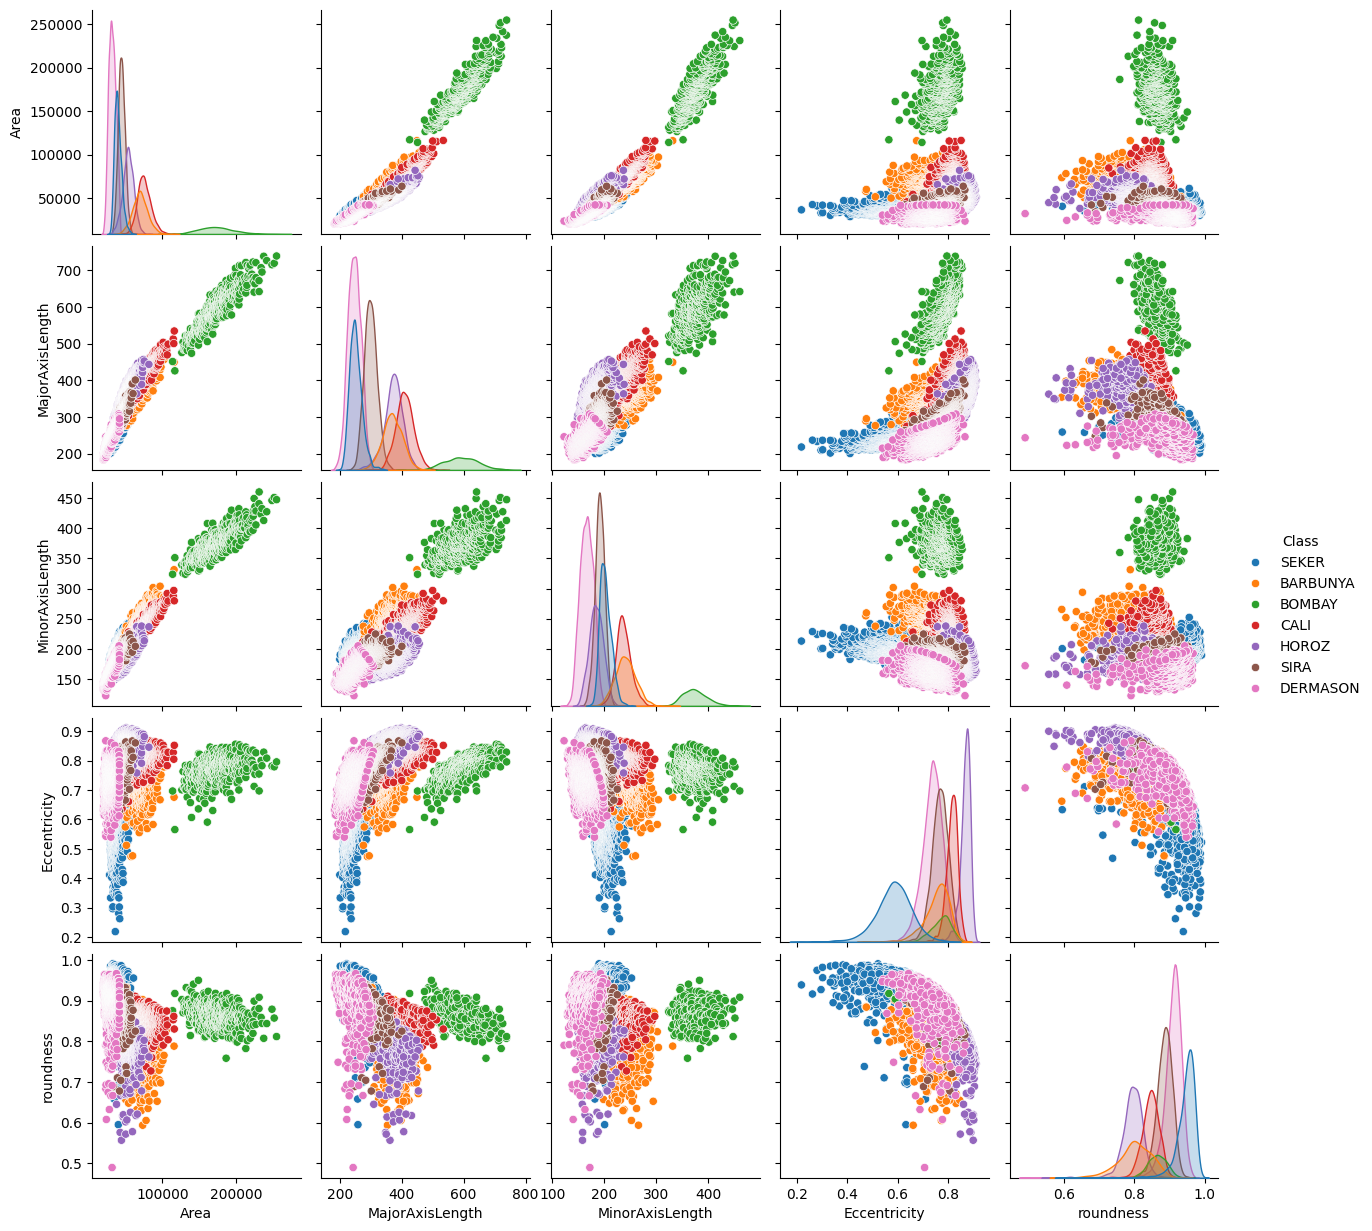

In [ ]:
import seaborn as sns

sns.pairplot(
   beans,
   vars=["Area", "MajorAxisLength", "MinorAxisLength", "Eccentricity", "roundness"],
   hue="Class",
);


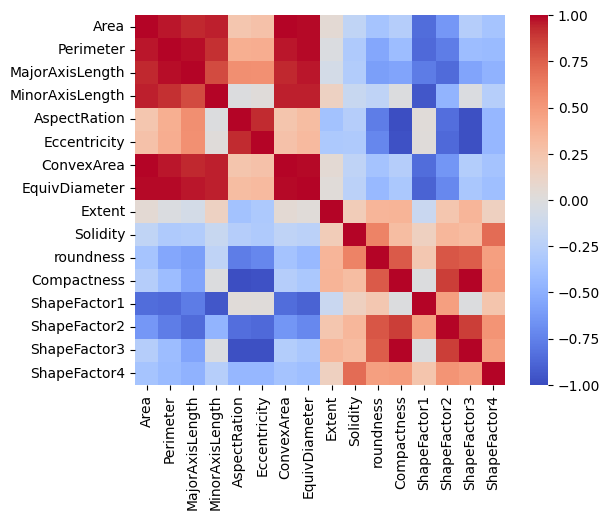

In [ ]:
import matplotlib.pyplot as plt

correlation = beans.corr(numeric_only=True)

# Create a square heatmap with center at 0
sns.heatmap(correlation, center=0, square=True, cmap="coolwarm", vmin=-1, vmax=1)

plt.show()


In [ ]:
#Running an AutoML training job

In [ ]:
ds = ai.TabularDataset.create(
   display_name="dry_bean_dataset", gcs_source=gcs_path
)


Creating TabularDataset
Create TabularDataset backing LRO: projects/763050299616/locations/us-central1/datasets/8248287192191860736/operations/8590233160946548736
TabularDataset created. Resource name: projects/763050299616/locations/us-central1/datasets/8248287192191860736
To use this TabularDataset in another session:
ds = aiplatform.TabularDataset('projects/763050299616/locations/us-central1/datasets/8248287192191860736')


In [ ]:
type(ds)

google.cloud.aiplatform.datasets.tabular_dataset.TabularDataset

In [ ]:
job = ai.AutoMLTabularTrainingJob(
   display_name="dry-bean-classification",
   optimization_prediction_type="classification",
)


In [ ]:
model = job.run(
   dataset=ds,
   target_column="Class",
   training_fraction_split=0.8,
   validation_fraction_split=0.1,
   test_fraction_split=0.1,
   model_display_name="baseline-classification-model",
   disable_early_stopping=False,
)


No column transformations provided, so now retrieving columns from dataset in order to set default column transformations.
The column transformation of type 'auto' was set for the following columns: ['Area', 'AspectRation', 'Solidity', 'Compactness', 'ShapeFactor1', 'Extent', 'MinorAxisLength', 'ShapeFactor4', 'EquivDiameter', 'MajorAxisLength', 'Eccentricity', 'ShapeFactor3', 'roundness', 'ConvexArea', 'Perimeter', 'ShapeFactor2'].
View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/43390078906531840?project=763050299616
AutoMLTabularTrainingJob projects/763050299616/locations/us-central1/trainingPipelines/43390078906531840 current state:
PipelineState.PIPELINE_STATE_PENDING
AutoMLTabularTrainingJob projects/763050299616/locations/us-central1/trainingPipelines/43390078906531840 current state:
PipelineState.PIPELINE_STATE_PENDING
AutoMLTabularTrainingJob projects/763050299616/locations/us-central1/trainingPipelines/43390078906531840 current state:

In [ ]:
endpoint = model.deploy(machine_type="n1-standard-4")


Creating Endpoint
Create Endpoint backing LRO: projects/763050299616/locations/us-central1/endpoints/6868648039205044224/operations/5619528664556240896
Endpoint created. Resource name: projects/763050299616/locations/us-central1/endpoints/6868648039205044224
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/763050299616/locations/us-central1/endpoints/6868648039205044224')
Deploying model to Endpoint : projects/763050299616/locations/us-central1/endpoints/6868648039205044224
Deploy Endpoint model backing LRO: projects/763050299616/locations/us-central1/endpoints/6868648039205044224/operations/1464395058353537024
Endpoint model deployed. Resource name: projects/763050299616/locations/us-central1/endpoints/6868648039205044224


In [ ]:
prediction = endpoint.predict(
   [
       {
           "Area": "30099",
           "Perimeter": "638.8209999999999",
           "MajorAxisLength": "237.14191130827916",
           "MinorAxisLength": "162.3034300714102",
           "AspectRation": "1.4611022774068396",
           "Eccentricity": "0.7290928631259719",
           "ConvexArea": "30477",
           "EquivDiameter": "195.76321681302556",
           "Extent": "0.8036043251902283",
           "Solidity": "0.9875972044492568",
           "roundness": "0.9268374259664279",
           "Compactness": "0.8255108332939839",
           "ShapeFactor1": "0.007878730566074592",
           "ShapeFactor2": "0.002256976927384019",
           "ShapeFactor3": "0.6814681358857279",
           "ShapeFactor4": "0.9956946453228307",
       }
   ]
)

print(prediction)


Prediction(predictions=[{'scores': [0.9980142712593079, 0.001753349439240992, 7.269846719282214e-06, 0.0002237715962110087, 2.194741881567097e-07, 2.940572016996157e-07, 8.458270599476236e-07], 'classes': ['DERMASON', 'SIRA', 'SEKER', 'HOROZ', 'CALI', 'BARBUNYA', 'BOMBAY']}], deployed_model_id='1196742540531859456', metadata=None, model_version_id='1', model_resource_name='projects/763050299616/locations/us-central1/models/7582028775492157440', explanations=None)
